In [64]:
import sys
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/AVATAR_motionMap')
import FileManager.csvload as acl
sys.path.insert(0, 'C:/Users/MyPC/Desktop/git/kp_moseq/keypoint-moseq/project')
import SDSBD_trainset2.params as params

import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import time
from datetime import date
import os
import keypoint_moseq as kpms
import keypoint_moseq .analysis as kpmsa
preSD_extrR = params.preSD_extrR
preSD_extrS = params.preSD_extrS
postSD_extrR = params.postSD_extrR
postSD_extrS = params.postSD_extrS
postSD_defeated = params.postSD_defeated
postSD_control = params.postSD_control

# parameters setting
start = params.start    # analysis start frame of the video
end = params.end        # analysis end frame of the video
syllable_analyzed = 6 #params.core_syllable_num
filelist_group1 = acl.get_csv_paths(preSD_extrR)    #[]
filelist_group2 = acl.get_csv_paths(preSD_extrS)
dataset = filelist_group1 + filelist_group2
dataset_class = [0]*len(filelist_group1) + [1]*len(filelist_group2)
if len(dataset) != len(dataset_class):
    print('Error: dataset and dataset_class should have the same length')
    sys.exit()


# read "sylable reindexed" column from each csv file and store it in a dictionary
data_moseq = {}  # Initialize an empty dictionary
for file, group in zip(dataset, dataset_class):
    file_name = os.path.splitext(os.path.basename(file))[0]
    data_moseq[file_name] = {}  # Create a new dictionary for each file with the file as the key
    data_moseq[file_name]['class'] = group  # Store the class of the file in the dictionary
    
    # Read the csv file
    df = pd.read_csv(file)
    df = df[start:end]
    
    # Convert the 'syllables reindexed' column to a numpy array, wrap it in a list, and store it in the dictionary
    data_moseq[file_name]['syllables reindexed'] = [df['syllables reindexed'].to_numpy(dtype=int)]
    frequencies, durations = kpmsa.get_syllable_statistics(data_moseq[file_name]['syllables reindexed'], max_syllable=100, count='frequency')

    # Calculate the relative frequencies
    total_frequency = sum(frequencies.values())
    relative_frequencies = {k: v / total_frequency for k, v in frequencies.items()}
    relative_frequencies = {key: value for key, value in relative_frequencies.items() if key in range(syllable_analyzed)}

    # Store relative frequencies in the dictionary
    data_moseq[file_name]['syllables relative frequency'] = relative_frequencies
    data_moseq[file_name]['syllables durations'] = durations

1-1. QDA (Quadratic Discriminant Analysis) model training

In [79]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score

# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    relative_frequency_values = list(data['syllables relative frequency'].values())
    X.append(relative_frequency_values)
    response_value = data['class']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=200, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    qda.fit(X_train, y_train) # 모델 훈련
    predictions = qda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("Average accuracy: ", np.mean(scores))

Average accuracy:  0.7086285714285715


1-2. Permutation test

Variables are collinearVariables are collinearVariables are collinearVariables are collinearVariables are collinearVariables are collinearVariables are collinearVariables are collinear

Model score: 0.7114428571428572
Permutation test p-value: 0.04295704295704296


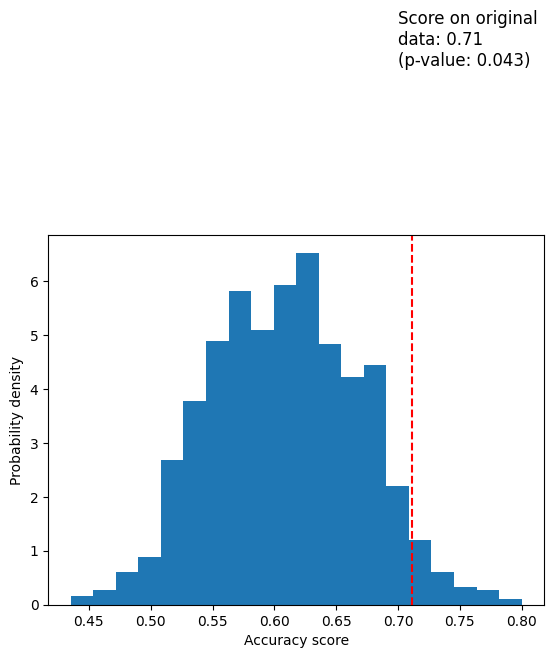

In [66]:
import matplotlib.pyplot as plt
# 분석기 초기화
qda = QuadraticDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(qda, X, y, scoring="accuracy", cv=cv, n_permutations=500, n_jobs=1)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)

fig, ax = plt.subplots()

ax.hist(permutation_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability density")

1-3. Confusion matrix

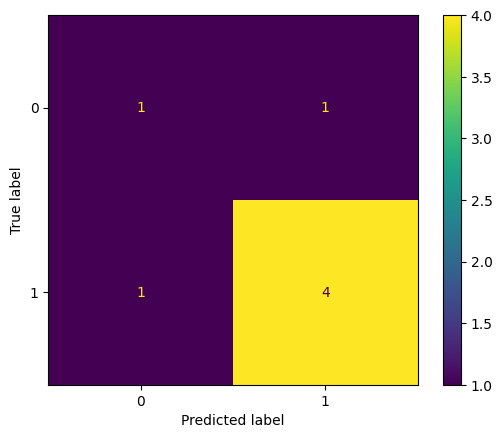

True Positive : 4
True Negative : 1
False Positive : 1
False Negative : 1
Precision score 0.8


In [67]:
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix

ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()
 
tn, fp, fn, tp = confusion_matrix(list(y_test), list(predictions), labels=[0, 1]).ravel()
 
print('True Positive :', tp)
print('True Negative :', tn)
print('False Positive :', fp)
print('False Negative :', fn)
print("Precision score", precision_score(y_test,predictions))

2-1. Linear discriminant analysis

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import accuracy_score

# Prepare data
X = []  # Features
y = []  # Response
for file_name, data in data_moseq.items():
    relative_frequency_values = list(data['syllables relative frequency'].values())
    X.append(relative_frequency_values)
    response_value = data['class']
    y.append(response_value)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# Repeated Stratified K-Fold 객체 생성
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1000, random_state=42)

# 결과 저장을 위한 리스트
scores = []

# 교차 검증 수행
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lda.fit(X_train, y_train) # 모델 훈련
    predictions = lda.predict(X_test) # 예측
    score = accuracy_score(y_test, predictions) # 정확도 계산
    scores.append(score)

# 평균 정확도 출력
print("Average accuracy: ", np.mean(scores))

# 분석기 초기화
lda = LinearDiscriminantAnalysis()

# 순열 테스트 수행
score, permutation_scores, pvalue = permutation_test_score(lda, X, y, scoring="accuracy", cv=cv, n_permutations=1000, n_jobs=1)

# 결과 출력
print("Model score: %s" % score)
print("Permutation test p-value: %s" % pvalue)
